In [5]:
# read data: 30 ICs 
import nipype.interfaces.io as nio
import os
PD_ICA_file='/templateflow/PD_ICAs';
ICs_list=list(range(30))
ICs_list=["{:0>4d}".format(x) for x in ICs_list]
# file import
ds_ic = nio.DataGrabber(infields=['IC_id'])
ds_ic.inputs.base_directory = PD_ICA_file # database
ds_ic.inputs.template = 'melodic_IC_%4s.nii.gz' # from cwd
ds_ic.inputs.sort_filelist = True
ds_ic.inputs.IC_id = ICs_list
res_ic = ds_ic.run()
ic_list=res_ic.outputs.outfiles
# read local ic
PD_ICA_local_file='/output/PD_ICA/ICA_local/stats';
ICs_local_list=[x+1 for x in list(range(19))]
#ICs_local_list=["{:0>4d}".format(x) for x in ICs_local_list]
# file import
ds_local_ic = nio.DataGrabber(infields=['IC_id'])
ds_local_ic.inputs.base_directory = PD_ICA_local_file # database
ds_local_ic.inputs.template = 'thresh_zstat%s.nii.gz' # from cwd
ds_local_ic.inputs.sort_filelist = True
ds_local_ic.inputs.IC_id = ICs_local_list
res_local_ic = ds_local_ic.run()
ic_local_list=res_local_ic.outputs.outfiles
#print(ic_local_list)
# read data: 3 study groups by sub_list 
GROUPS=['PD','ET','NC']
OUT_DIR='/output/PD_ICA/'
SUB_LIST=[]; AGE_LIST=[]; JCOB_LIST=[];

for group_name in GROUPS:
    current_group=group_name
    current_sub_list_file = '/codes/devel/PD_Marker/'+current_group+'_info_ICA.list'
    # create dir for output
    current_OUT_DIR=OUT_DIR+current_group+'/'
    if not os.path.exists(current_OUT_DIR):
        os.makedirs(current_OUT_DIR)
    #read sub list
    with open(current_sub_list_file, 'r') as f_sub:
        sub_list_raw= f_sub.readlines()
    sub_list = [x[0:-1].split('\t')[0] for x in sub_list_raw] # remove 
    age_list = [int(x[0:-1].split('\t')[1]) for x in sub_list_raw]
    SUB_LIST.append(sub_list);  AGE_LIST.append(age_list);
    N_sub=len(sub_list)
    print(group_name, ': ', N_sub, sub_list, age_list)
    # grab group Jacobians
    ds_jacobian = nio.DataGrabber(infields=['sub_id'])
    ds_jacobian.inputs.base_directory = current_OUT_DIR # database
    ds_jacobian.inputs.template = '%s_desc-preproc_T1w_space-MNI2009c_Warp_Jacobian.nii.gz' # from cwd
    ds_jacobian.inputs.sort_filelist = True
    ds_jacobian.inputs.sub_id = sub_list
    res_jacobian = ds_jacobian.run()
    jacobian_list=res_jacobian.outputs.outfiles
    JCOB_LIST.append(jacobian_list)
pd_sub_list = SUB_LIST[0]; et_sub_list = SUB_LIST[1]; nc_sub_list = SUB_LIST[2]; 
pd_age_list = AGE_LIST[0]; et_age_list = AGE_LIST[1]; nc_age_list = AGE_LIST[2];
pd_jaco_list=JCOB_LIST[0]; et_jaco_list=JCOB_LIST[1]; nc_jaco_list=JCOB_LIST[2];

['/output/PD_ICA/ICA_local/stats/thresh_zstat1.nii.gz', '/output/PD_ICA/ICA_local/stats/thresh_zstat2.nii.gz', '/output/PD_ICA/ICA_local/stats/thresh_zstat3.nii.gz', '/output/PD_ICA/ICA_local/stats/thresh_zstat4.nii.gz', '/output/PD_ICA/ICA_local/stats/thresh_zstat5.nii.gz', '/output/PD_ICA/ICA_local/stats/thresh_zstat6.nii.gz', '/output/PD_ICA/ICA_local/stats/thresh_zstat7.nii.gz', '/output/PD_ICA/ICA_local/stats/thresh_zstat8.nii.gz', '/output/PD_ICA/ICA_local/stats/thresh_zstat9.nii.gz', '/output/PD_ICA/ICA_local/stats/thresh_zstat10.nii.gz', '/output/PD_ICA/ICA_local/stats/thresh_zstat11.nii.gz', '/output/PD_ICA/ICA_local/stats/thresh_zstat12.nii.gz', '/output/PD_ICA/ICA_local/stats/thresh_zstat13.nii.gz', '/output/PD_ICA/ICA_local/stats/thresh_zstat14.nii.gz', '/output/PD_ICA/ICA_local/stats/thresh_zstat15.nii.gz', '/output/PD_ICA/ICA_local/stats/thresh_zstat16.nii.gz', '/output/PD_ICA/ICA_local/stats/thresh_zstat17.nii.gz', '/output/PD_ICA/ICA_local/stats/thresh_zstat18.nii.gz', 

In [ ]:
# read all group Jacobian data， and image multiply IMG*IMG
#ic_list
#pd_sub_list,  et_sub_list,  nc_sub_list; 
#pd_age_list,  et_age_list,  nc_age_list;
#pd_jaco_list, et_jaco_list, nc_jaco_list;
import nibabel as nib
import time
i_PD_IC=7
pd_jaco_x_list=[]; et_jaco_x_list=[]; nc_jaco_x_list=[]
PD_ICA_img=nib.load(ic_list[i_PD_IC]);
def grab_groupXICA(ic_img, img_list):
    import nibabel as nib
    from nilearn.image import resample_to_img
    from nilearn.image import math_img
    from scipy import stats
    import numpy as np
    x_list=[]; y_list=[];
    N_sub=len(img_list)
    #print('gourp++')
    for i in range(N_sub):
        # cal img * img
        sub_img=nib.load(img_list[i])
        sub_img_re = resample_to_img(sub_img, ic_img)
        sub_img_x  = math_img("img1 * img2", img1=ic_img, img2=sub_img_re)
        x_list.append(sub_img_x)
        # cal naive corr
        ic_data = ic_img.get_fdata().reshape(-1);
        nz_pos=np.flatnonzero(ic_data)
        ic_val=list(ic_data.ravel()[nz_pos])
        sub_dat = sub_img_re.get_fdata().reshape(-1);
        sub_val=list(stats.zscore(sub_dat.ravel()[nz_pos]))
        y_list.append(np.corrcoef(sub_val, ic_val)[0,1])
    return x_list, y_list
##
ICx_OUT_DIR = '/output/PD_ICA/IC_Ximg/'
N_IC=len(ic_list); N_PD=len(pd_sub_list); N_ET=len(et_sub_list) ;N_NC=len(nc_sub_list);
# PD group
t0=time.time()
pd_jaco_x_list=[grab_groupXICA(nib.load(x), pd_jaco_list) for x in ic_list];
img_all_icXpd = np.array([x[0][:] for x in pd_jaco_x_list])
for i_ic in range(N_IC):
    print('PD: ', i_ic, N_PD)
    for i_sub in range(N_PD):
        nib.save(img_all_icXpd[i_ic][i_sub], ICx_OUT_DIR+pd_sub_list[i_sub]+'-xIC'+str(i_ic)+'.nii.gz');
print('PD group all IC takes: ', str(time.time()-t0))
# ET Group
et_jaco_x_list=[grab_groupXICA(nib.load(x), et_jaco_list) for x in ic_list];
img_all_icXet = np.array([x[0][:] for x in et_jaco_x_list])
for i_ic in range(N_IC):
    print('ET: ', i_ic, N_ET)
    for i_sub in range(N_ET):
        nib.save(img_all_icXet[i_ic][i_sub], ICx_OUT_DIR+et_sub_list[i_sub]+'-xIC'+str(i_ic)+'.nii.gz');
print('ET group all IC takes: ', str(time.time()-t0))

In [61]:
import numpy as np
import nibabel as nib
import pandas as pd
print(np.shape(pd_jaco_x_list))
#df_1=pd.read_csv('data.csv')
mean_all_pd = pd.DataFrame(np.array([x[1][:] for x in pd_jaco_x_list]))
mean_all_et = pd.DataFrame(np.array([x[1][:] for x in et_jaco_x_list]))
mean_all_pd.to_csv('mean_all_pd.csv')
mean_all_et.to_csv('mean_all_et.csv')
print(np.shape(mean_all_pd))
print(np.shape(mean_all_et))

(30, 2, 40)
(30, 40)
(30, 30)


In [15]:
import nibabel as nib
import time
ICx_OUT_DIR = '/output/PD_ICA/IC_Ximg/'
N_IC=len(ic_list); N_PD=len(pd_sub_list); N_ET=len(et_sub_list) ;N_NC=len(nc_sub_list);
nc_jaco_x_list=[]
i_PD_IC=7
PD_ICA_img=nib.load(ic_list[i_PD_IC]);

def grab_groupXICA_all_sv(ic_list, img_list, id_list, out_dir):
    import nibabel as nib
    from nilearn.image import resample_to_img
    from nilearn.image import math_img
    from scipy import stats
    import numpy as np
    x_list=[]; 
    N_ic=len(ic_list);
    N_sub=len(img_list);
    #print('gourp++')
    for j in range(N_ic):
        y_list=[]
        for i in range(N_sub):
            # cal img * img
            ic_img=nib.load(ic_list[j])
            sub_img=nib.load(img_list[i])
            sub_img_re = resample_to_img(sub_img, ic_img)
            sub_img_x  = math_img("img1 * img2", img1=ic_img, img2=sub_img_re)
            #nib.save(sub_img_x, out_dir+id_list[i]+'-xIC'+str(j)+'.nii.gz');
            sub_img_x
            # cal naive corr
            ic_data = ic_img.get_fdata().reshape(-1);
            nz_pos=np.flatnonzero(ic_data)
            ic_val=list(ic_data.ravel()[nz_pos])
            sub_dat = sub_img_re.get_fdata().reshape(-1);
            sub_val=list(stats.zscore(sub_dat.ravel()[nz_pos]))
            y_list.append([sub_img_x, np.corrcoef(sub_val, ic_val)[0,1]])
        x_list.append(y_list)
    return x_list
##
ICx_OUT_DIR = '/output/PD_ICA/IC_Ximg/'
N_IC=len(ic_list); N_PD=len(pd_sub_list); N_ET=len(et_sub_list) ;N_NC=len(nc_sub_list);
t0=time.time()
nc_jaco_x_list=grab_groupXICA_all_sv(ic_list, nc_jaco_list, nc_sub_list, ICx_OUT_DIR)
print('NC group all IC takes: ', str(time.time()-t0))

NC group all IC takes:  1362.9876294136047


In [10]:
def concatICImages(ic_list, group_list, id_list, DATA_DIR):
    from nilearn import image
    from nilearn.image import math_img
    from nilearn import plotting
    N_IC=len(ic_list); N_sub=len(group_list);
    IC_contactImag=[]
    for i_ic in range(N_IC):
        sub_images=[]
        for i_sub  in range(N_sub):
            sub_images.append(nib.load(DATA_DIR+id_list[i_sub]+'-xIC'+str(i_ic)+'.nii.gz'))
        img_mean = math_img("np.mean(img,axis=3)", img=image.concat_imgs(sub_images))
        IC_contactImag.append(img_mean)
    return IC_contactImag

ICx_OUT_DIR = '/output/PD_ICA/IC_Ximg/'
PD_mean=concatICImages(ic_list, pd_jaco_list, pd_sub_list, ICx_OUT_DIR)
ET_mean=concatICImages(ic_list, et_jaco_list, et_sub_list, ICx_OUT_DIR)
NC_mean=concatICImages(ic_list, nc_jaco_list, nc_sub_list, ICx_OUT_DIR)

In [16]:
# plot group mean X 30 ICs
from nilearn import plotting
#GROUPS=['PD','ET','NC']
PIC_OUT_DIR='/output/PD_ICA/pics'
atlas_09_masked='/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-02_T1w.nii.gz'
N_ic = len(ic_list)
#for i_ic in range(N_ic):
#plotting.plot_anat(ic_list[i_ic], title="IC "+str(i_ic), )
VMIN= 3; VMAX=16; # vmin=VMIN;
#plotting.plot_glass_brain(ic_list[i_ic], title='no th '+str(i_ic)+', with TH=0', display_mode='lyrz',
#                          black_bg=True, colorbar=True, plot_abs=False, vmin=VMIN, vmax=VMAX, threshold=5)
for i_ic in range(N_ic):
    plotting.plot_stat_map(PD_mean[i_ic], bg_img=atlas_09_masked, display_mode='z', threshold=3,  vmax=VMAX, \
                           title="PDXIC mean "+str(i_ic), draw_cross=False, cut_coords=[-16, -12, -7, -2,  8, 14, 20, 70], \
                           output_file=PIC_OUT_DIR+'/IC-'+str(i_ic)+'_PD-mean.png')
for i_ic in range(N_ic):
    plotting.plot_stat_map(ET_mean[i_ic], bg_img=atlas_09_masked, display_mode='z', threshold=3, vmax=VMAX, \
                           title="ETXIC mean "+str(i_ic), draw_cross=False, cut_coords=[-16, -12, -7, -2,  8, 14, 20, 70], \
                           output_file=PIC_OUT_DIR+'/IC-'+str(i_ic)+'_ET-mean.png')
for i_ic in range(N_ic):
    plotting.plot_stat_map(NC_mean[i_ic], bg_img=atlas_09_masked, display_mode='z', threshold=3, vmax=VMAX, \
                           title="NCXIC mean "+str(i_ic), draw_cross=False, cut_coords=[-16, -12, -7, -2,  8, 14, 20, 70], \
                           output_file=PIC_OUT_DIR+'/IC-'+str(i_ic)+'_NC-mean.png')

In [36]:
import numpy as np
import pandas as pd
#import nibabel as nib
#import pandas as pd
print(np.shape(nc_jaco_x_list))
print(nc_jaco_x_list[0][0][1])
mean_all_nc = pd.DataFrame(np.array([[y[1] for y in x] for x in nc_jaco_x_list]))
mean_all_nc.to_csv('mean_all_nc.csv')
#df_1=pd.read_csv('data.csv')
#mean_all_pd = pd.DataFrame(np.array([x[1][:] for x in pd_jaco_x_list]))
#mean_all_et = pd.DataFrame(np.array([x[1][:] for x in et_jaco_x_list]))
#mean_all_pd.to_csv('mean_all_pd.csv')
#mean_all_et.to_csv('mean_all_et.csv')
#print(np.shape(mean_all_pd))
#print(np.shape(mean_all_et))
np.shape(mean_all_et)

(30, 34, 2)
-0.021905575332871324


(30, 34)

In [ ]:
import seaborn as sns
df_1=pd.read_csv('mean_all_nc.csv')
df_2=pd.read_csv('mean_all_pd.csv')
df_3=pd.read_csv('mean_all_et.csv')
print(np.shape(df_1), np.shape(df_2), np.shape(df_3))
#sns.boxplot(x="x", y="y", data=df_1, palette="Set3") 


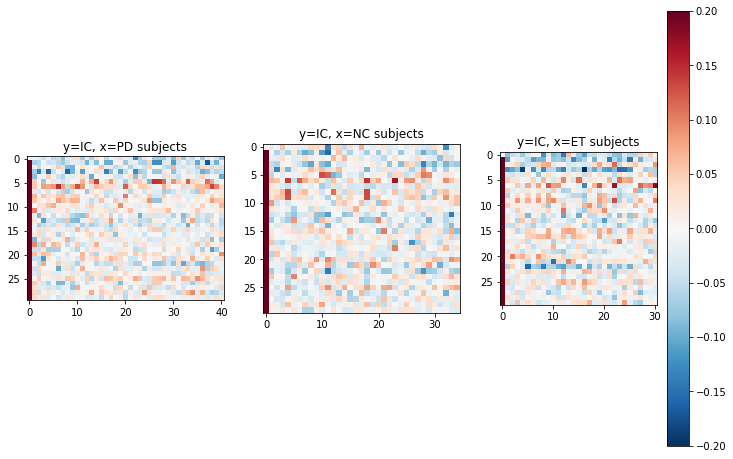

In [66]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use({'figure.figsize':(12, 8)})
vmin1=-.2; vmax1 = .2
df=[df_1, df_2, df_3];
# Fixing random state for reproducibility
#np.random.seed(19680801)
fig, axs = plt.subplots(1, 3)

cm = ['RdBu_r', 'viridis']
ax2 = axs[1]
pcm2 = ax2.imshow(df_1, cmap=cm[0], vmin= vmin1, vmax = vmax1)
ax2.set_title("y=IC, x=NC subjects")
#fig.colorbar(pcm1, ax=ax1)
ax1 = axs[0]
pcm1 = ax1.imshow(df_2, cmap=cm[0], vmin= vmin1, vmax = vmax1)
ax1.set_title("y=IC, x=PD subjects")
ax3 = axs[2]
pcm3 = ax3.imshow(df_3, cmap=cm[0], vmin= vmin1, vmax = vmax1)
ax3.set_title("y=IC, x=ET subjects")
fig.colorbar(pcm3, ax=ax3)
plt.show()

In [ ]:
# calculate image naive corr
import nibabel as nib
import numpy as np
PD_ICA_img=nib.load(ic_list[i_PD_IC]);
def cal_groupCorr(ic_img, img_list):
    import nibabel as nib
    from nilearn.image import resample_to_img
    from nilearn.image import math_img
    x_list=[];
    N_sub=len(img_list)
    for i in range(N_sub):
        sub_img=nib.load(img_list[i])
        sub_img_re = resample_to_img(sub_img, ic_img)
        #ic_data = ic_img.get_fdata().reshape(-1);
        nz_pos=np.flatnonzero(ic_data)
        ic_val=list(ic_data.ravel()[nz_pos])
        sub_val=list(stats.zscore(sub_dat.ravel()[nz_pos]))
        print(len(ic_val), len(sub_val))
        x_list.append(np.corrcoef(sub_dat, ic_val)[0,1])
    return x_list
pd_jaco_corr_list=cal_groupCorr(PD_ICA_img, pd_jaco_list); 
et_jaco_corr_list=cal_groupCorr(PD_ICA_img, et_jaco_list); 
nc_jaco_corr_list=cal_groupCorr(PD_ICA_img, nc_jaco_list);

In [9]:
pd_jaco_x_list_mean = [np.mean(x.get_fdata()) for x in pd_jaco_x_list]
et_jaco_x_list_mean = [np.mean(x.get_fdata()) for x in et_jaco_x_list]
nc_jaco_x_list_mean = [np.mean(x.get_fdata()) for x in nc_jaco_x_list]
#pd_age_list, et_age_list, nc_age_list;
#a=np.array(pd_jaco_x_list[0].get_fdata())
print(np.mean(pd_jaco_x_list_mean))
print(np.mean(et_jaco_x_list_mean))
print(np.mean(nc_jaco_x_list_mean))
import statsmodels

0.05656469500087711
0.057851655543776644
0.056640938817557565


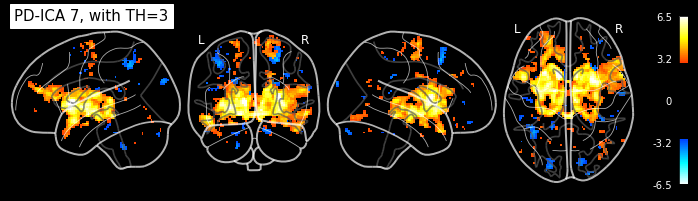

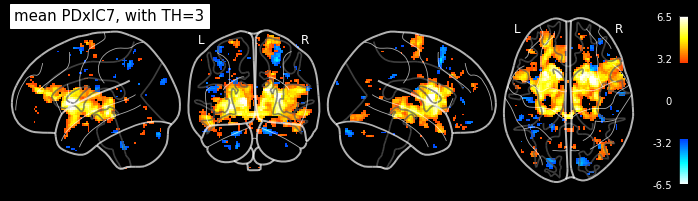

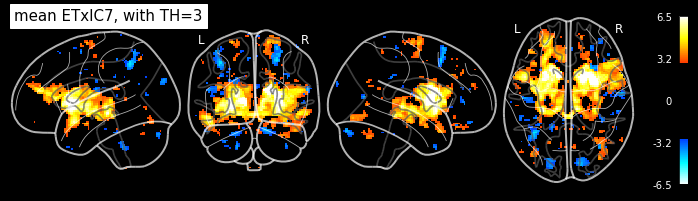

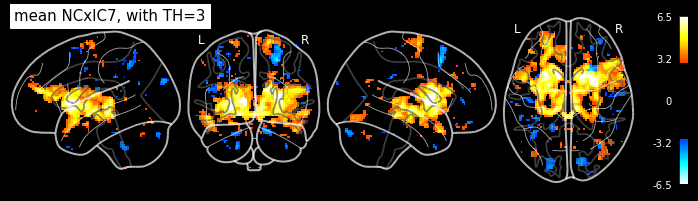

In [13]:
# plot group mean
TH=3
VMIN= 3; VMAX=6.5;
plotting.plot_glass_brain(PD_ICA_img, title='PD-ICA '+str(i_IC)+', with TH='+str(TH), display_mode='lyrz',
                          black_bg=True, colorbar=True, plot_abs=False, vmin=VMIN, vmax=VMAX, threshold=TH)
plotting.plot_glass_brain(pd4D_mean, title='mean PDxIC'+str(i_IC)+', with TH='+str(TH), display_mode='lyrz',
                          black_bg=True, colorbar=True, plot_abs=False, vmin=VMIN, vmax=VMAX, threshold=TH)
plotting.plot_glass_brain(et4D_mean, title='mean ETxIC'+str(i_IC)+', with TH='+str(TH), display_mode='lyrz',
                          black_bg=True, colorbar=True, plot_abs=False, vmin=VMIN, vmax=VMAX,threshold=TH)
plotting.plot_glass_brain(nc4D_mean, title='mean NCxIC'+str(i_IC)+', with TH='+str(TH), display_mode='lyrz',
                          black_bg=True, colorbar=True, plot_abs=False, vmin=VMIN, vmax=VMAX,threshold=TH)

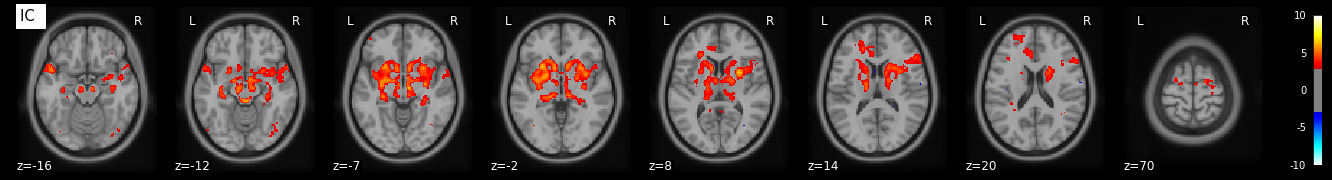

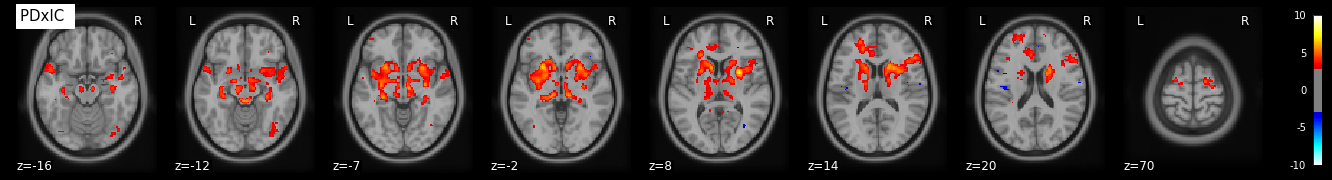

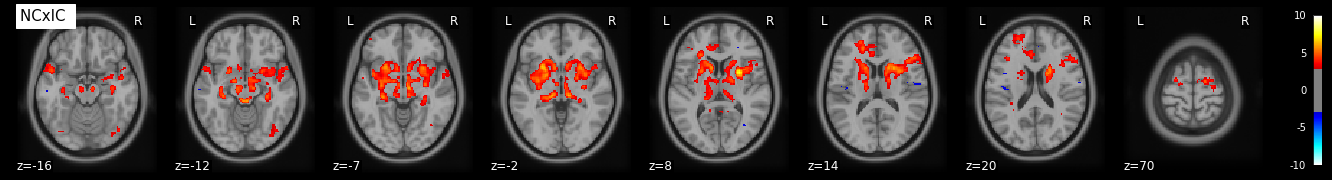

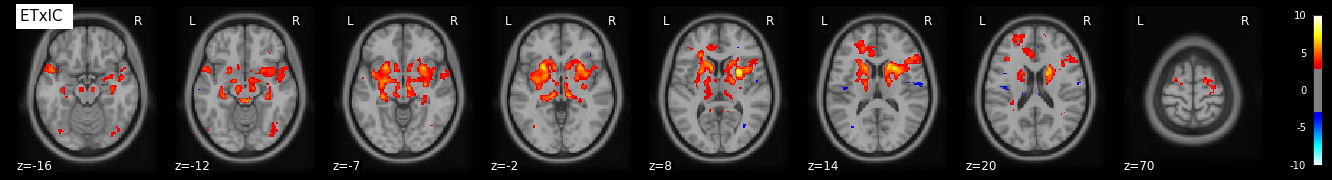

In [24]:
PD_ICA_SLICES=[-16, -12, -7, -2,  8, 14, 20, 70]
VMIN= 1; VMAX=10
plotting.plot_stat_map(PD_ICA_img, bg_img=atlas_09_masked, display_mode='z', threshold=3, \
                       title="IC ", vmax=VMAX, draw_cross=False, cut_coords=PD_ICA_SLICES)
plotting.plot_stat_map(pd4D_mean, bg_img=atlas_09_masked, display_mode='z', threshold=3, \
                       title="PDxIC ", vmax=VMAX, draw_cross=False, cut_coords=PD_ICA_SLICES)
plotting.plot_stat_map(nc4D_mean, bg_img=atlas_09_masked, display_mode='z', threshold=3, \
                       title="NCxIC ", vmax=VMAX, draw_cross=False, cut_coords=PD_ICA_SLICES)
plotting.plot_stat_map(et4D_mean, bg_img=atlas_09_masked, display_mode='z', threshold=3, \
                       title="ETxIC ", vmax=VMAX, draw_cross=False, cut_coords=PD_ICA_SLICES)

In [72]:
i_IC=0; i_sub=0; TH=0
ic_img = nib.load(ic_list[i_IC]);   
pd_img = nib.load(pd_list[i_sub]); 
nc_img = nib.load(nc_list[i_sub]);
#resampled_data1_img = resample_to_img(pd_img, ic_img)
#resampled_data2_img = resample_to_img(nc_img, ic_img)
def get_imageData(img_str, img_ic):
    import numpy as np
    import nibabel as nib
    from nilearn.image import resample_to_img
    img = nib.load(img_str);
    resampled_img = resample_to_img(img, ic_img)
    data_ic = ic_img.get_fdata()
    data = resampled_img.get_fdata()
    nz_pos=np.flatnonzero(data_ic)
    IC_val=data_ic.ravel()[nz_pos]
    img_val=stats.zscore(data.ravel()[nz_pos])
    return [data, IC_val, img_val]

pd_data = [get_image(x,ic_img) for x in pd_list]
nc_data = [get_image(x,ic_img) for x in nc_list]
print(np.sum(pd_data[0][0]))
print(np.sum(pd_data[1][0]))

1060051.450135765
1059669.8242368363


In [77]:
from scipy import stats
pd_mean=[np.mean(x[0]) for x in pd_data]
nc_mean=[np.mean(x[0]) for x in nc_data]
print(stats.ttest_ind(pd_mean, nc_mean, equal_var=True))
print(stats.ttest_ind(pd_mean, nc_mean, equal_var=False))

Ttest_indResult(statistic=-1.3711034291991173, pvalue=0.17417680771735503)
Ttest_indResult(statistic=-1.206577160233266, pvalue=0.23464457921760362)


In [81]:
i_IC=0; i_sub=0; TH=0
ic_img = nib.load(ic_list[i_IC]);   
pd_img = nib.load(pd_list[i_sub]); 
nc_img = nib.load(nc_list[i_sub]);
def get_xImageData(img_str, img_ic):
    import numpy as np
    import nibabel as nib
    from nilearn.image import resample_to_img
    img = nib.load(img_str);
    resampled_img = resample_to_img(img, ic_img)
    x_img = math_img("img1 * img2", img1=img_ic, img2=resampled_img)
    data_ic = ic_img.get_fdata()
    data = x_img.get_fdata()
    return data
xpd_data = [get_xImageData(x,ic_img) for x in pd_list]
xnc_data = [get_xImageData(x,ic_img) for x in nc_list]

ValueError: operands could not be broadcast together with shapes (101,119,97) (235818,) 

In [84]:
xpd_mean=[np.mean(x) for x in xpd_data]
xnc_mean=[np.mean(x) for x in xnc_data]
print(stats.ttest_ind(xpd_mean, xnc_mean, equal_var=True))
print(stats.ttest_ind(xpd_mean, xnc_mean, equal_var=False))

Ttest_indResult(statistic=-2.611701552984461, pvalue=0.010755738938827877)
Ttest_indResult(statistic=-2.5044536648945304, pvalue=0.015007318082083668)


In [87]:
xpd_var=[np.var(x) for x in xpd_data]
xnc_var=[np.var(x) for x in xnc_data]
print(stats.ttest_ind(xpd_var, xnc_var, equal_var=True))
print(stats.ttest_ind(xpd_var, xnc_var, equal_var=False))

Ttest_indResult(statistic=-1.8994027071264423, pvalue=0.06111577484793034)
Ttest_indResult(statistic=-1.8138974536096693, pvalue=0.07480459323692994)
